# DQN - Deep Q-Network  (TensorFlow) - Play Atari game.

In this notebook, we will use DQN with **experience replay** and **target networks** from `listing6_1` to train the agent to play Atari game. Most of the implementation will be same as previous one except some pre-processing to make Atari game playing trainable with DQN. 

The deep learning approach combined with Q-Learinng and word `DQN` was coined in this paper. We have tried to broadly follow the steps of the paper in this notebook

Paper: [Playing Atari with Deep Reinforcement Learning](https://arxiv.org/pdf/1312.5602.pdf)

### Recap from last notebook

$$ 
\DeclareMathOperator*{\max}{max}$$

Q Learning control is carried out by sampling step by step and updating Q values at each step. We use ε-greedy policy to explore and generate samples. However, the policy learnt is a deterministic greedy policy with no exploration. We can carryout updates online i.e. we take a step and use `(current state, action, reward and next_state)` tuple to update. 

In case of function approximation using neural network, the input to the network is the state and output is the q(s,a) for all the actions in the state `s`. It is denoted as $ \hat{q}(s_t,a; w_{t}) $, where $w_{t}$ is the weigths of the neural network which we are trying to learn as part of DQN learning. 

We use two networks, one target network to get the max q-value of next state denoted by $ \max_a \hat {q}(s_{t+1},a; w^{-}_{t}) $ and the primary network with weights $w_{t}$ which we are updated based on back propagation of the TD error through the network.

The Update equation is given below. This is the online version:
$$ w_{t+1} \leftarrow w_t + \alpha [ R_{t+1} + \gamma . \max_{a} \hat{q}(S_{t+1},a,w^{-}_{t}) – \hat{q}(S_t,A_t,w_t)] \nabla \hat{q}(S_t,A_t,w_t)$$

Online update with neural network with millions of weights does not work well. Accordingly, We use experience replay (aka Replay Buffer).  We use a behavior policy to explore the environment and store the samples `(s, a, r, s', done)` in a buffer. The samples are generated using an exploratory behavior policy while we improve a deterministic target policy using q-values. 

Therefore, we can always use older samples from behavior policy and apply them again and again. We can keep the buffer size fixed to some pre-determined size and keep deleting the older samples as we collect new ones. This process makes learning sample efficient by reusing a sample multiple times and also removing temporal dependence of the samples we would otherwise see while following a trajectory.

The update equation with batch update with minor modifications is given below. We collect samples of transitions (current state, action, reward, next state) in a buffer. Where each sample is denoted as a tuple: 

$$ (s_{i}, a_{i}, r_{i}, s^{'}_{i}, done_{i})$$

Subscript (i) denotes ith sample. We take N samples from experience replay selecting randomly and update the weights. Subscript (t) denotes the index of weight updates. If the current state is done, as denoted by `done` flag, the target is just the reward as terminal states have zero value. The final update equation is as given below:

$$w_{t+1} \leftarrow w_t + \alpha \frac{1}{N} \sum_{i=1}^{N} \left[ r_i + \left( (1-done_i) . \gamma .  \max_{a^{'}_{i}} \hat{q}(s_{i}^{'},a_{i}^{'};w^{-}_{t}) \right) – \hat{q}(s_i,a_i;w_t) \right] \nabla \hat{q}(s_i,a_i;w_t)$$



In [3]:
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Model
import gym
import numpy as np 
import matplotlib.pyplot as plt
from scipy.signal import convolve, gaussian

import os
import io
import base64
import time
import glob
from IPython.display import HTML

%matplotlib inline


### Environment - Atari Breakout 

We can use the setup here to run on any environment which has state as a single vector and actions are discrete. We will build it on Atari Breakout.

In [4]:
def make_env(env_name, seed=None):
    # remove time limit wrapper from environment
    env = gym.make(env_name).unwrapped
    if seed is not None:
        env.seed(seed)
    return env

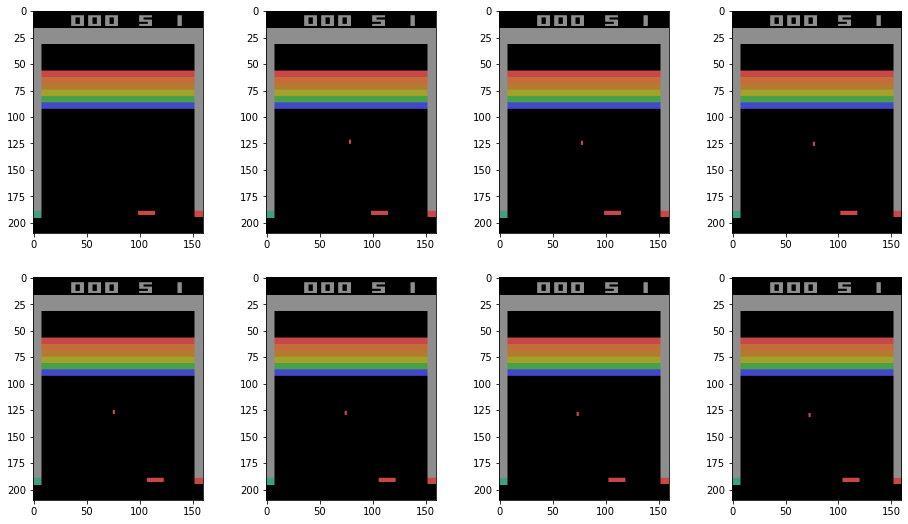

In [5]:
env_name = "BreakoutNoFrameskip-v4"

env = make_env(env_name)
env.reset()



n_cols = 4
n_rows = 2
fig = plt.figure(figsize=(16, 9))

for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(env.render('rgb_array'))
        env.step(env.action_space.sample())
plt.show()

#### We can play the game

use `A` and `D` on keyboard to move the bat and `Space-bar` to start. use `Esc` to kill the game.

**NOTE: Running the cell below may crash your kernel in Mac. If you face that problem, please comment the cell below or do not run it**.

In [5]:
from gym.utils.play import play

play(env=gym.make(env_name), zoom=2, fps=30)

pygame 2.0.1 (SDL 2.0.14, Python 3.8.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


### Pre processing

Atari images are 210x160x3 pixels but we will scale it down and also convert to gray-scale to reduce the size and make the game learn faster from smaller image sizes. We will also stack 4 last frames as input observation. This is done to capture the motion of the ball and bat which would not be visible in a single frame of game. OpenAI Gym library has ObservationWrappers to provide all these pre-processing out of the box. We will also be clipping rewards with just the sign of rewards. This is following the approach outlined in original paper. Let us build our preprocessor below

In [6]:
from gym.wrappers import AtariPreprocessing
from gym.wrappers import FrameStack
from gym.wrappers import TransformReward
from gym.core import ObservationWrapper

# in tensorflow imgs have shape [h, w, c] instead of torch imgs with shape [c, h, w]

class SwapChannelWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)

        self.img_size = [self.observation_space.shape[i]
                         for i in [1, 2, 0]
                         ]
        self.observation_space = gym.spaces.Box(0.0, 1.0, self.img_size)

    def observation(self, img):
        """what happens to each observation"""
        img = img[:].transpose(1, 2, 0) #we also remove the lazywrapper to swap the axis
        return img

def make_env(env_name, clip_rewards=True, seed=None):
    env = gym.make(env_name)
    if seed is not None:
        env.seed(seed)
    env = AtariPreprocessing(env, screen_size=84, scale_obs=True)
    env = FrameStack(env, num_stack=4)
    if clip_rewards:
        env = TransformReward(env, lambda r: np.sign(r))
    env = SwapChannelWrapper(env)
    return env

env = make_env(env_name)
env.reset()
n_actions = env.action_space.n
state_shape = env.observation_space.shape
print(state_shape)

(84, 84, 4)


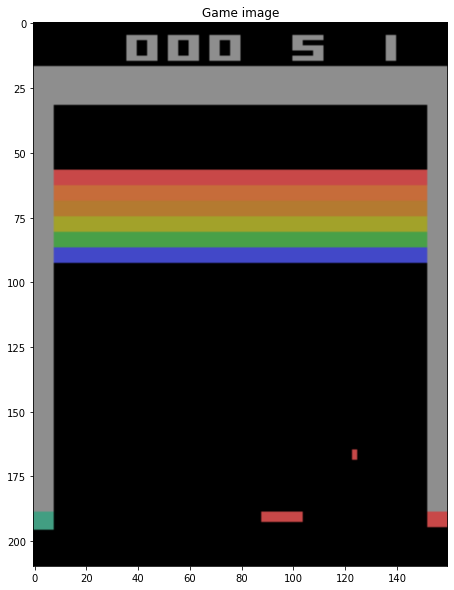

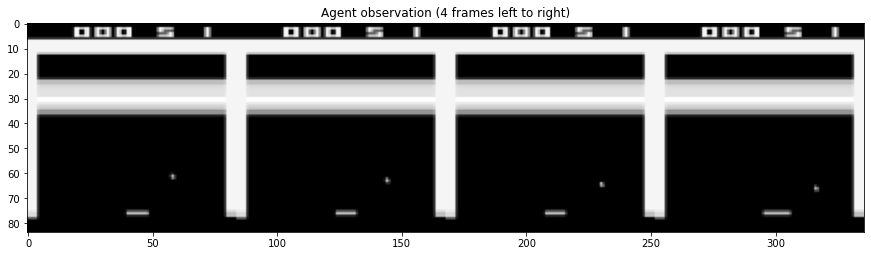

In [7]:
for _ in range(12):
    obs, _, _, _ = env.step(env.action_space.sample())

plt.figure(figsize=[12,10])
plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()

obs = np.transpose(obs,[0,2,1]) #move axes
obs = obs.reshape((obs.shape[0], -1))


plt.figure(figsize=[15,15])
plt.title("Agent observation (4 frames left to right)")
plt.imshow(obs, cmap='gray')
plt.show()

### Building a network using tensorflow

Let us build a DQN agent using the architecture suggested in paper.

    Observation:
        tensorflow 84x84x4 tensorflow has channels in the last dimension
        input: [batch_size, 84, 84, 4]
        1st hidden layer: 16 8x8 filters with stride 4 and RelU activation
        2nd hidden layer: 32 4x4 filters with stride of 2 and RelU activation
        3nd hidden layer: Linear layer with 256 outputs and RelU activatrion
        output layer: Linear with n_actions units with no activation

To build this network, after 2 layers of convolution, we will flatten the layers. To connect this to Dense(Linear) layer, we can calculate the number of units entering dense layer. We do so using the formula for Conv2D output. **We needed this for PyTorch but TensorFlow computes this internally and we do not need to provide the same explicitly.**

`out_dim = (in_dim - (kernel_size - 1) - 1) // stride  + 1`

In [7]:
def conv2d_size_out(size, kernel_size, stride):
    return (size - (kernel_size - 1) - 1) // stride  + 1


In [8]:
# for the network above
# 1st Conv layer output size
conv1 = conv2d_size_out(84, 8, 4)
print('Conv1: ', conv1)
conv2 = conv2d_size_out(conv1, 4, 2)
print('Conv1: ', conv2)

#number of units entering dense layer would be
print("Input to Dense layer:", conv2*conv2*32) #32 is number of filters coming out in 2nd conv layer

Conv1:  20
Conv1:  9
Input to Dense layer: 2592


In [9]:
class DQNAgent:
    def __init__(self, state_shape, n_actions, epsilon=0):

        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape
        
        # a simple NN with state_dim as input vector (inout is state s)
        # and self.n_actions as output vector of logits of q(s, a)
        self.model = tf.keras.models.Sequential()
        self.model.add(tf.keras.Input(shape=state_shape))
        self.model.add(tf.keras.layers.Conv2D(16, kernel_size=8, strides=4, activation='relu'))
        self.model.add(tf.keras.layers.Conv2D(32, kernel_size=4, strides=2, activation='relu'))
        self.model.add(tf.keras.layers.Flatten())
        self.model.add(tf.keras.layers.Dense(256, activation='relu'))
        self.model.add(tf.keras.layers.Dense(n_actions))
        
    def __call__(self, state_t):
        # pass the state at time t through the newrok to get Q(s,a)
        qvalues = self.model(state_t)
        return qvalues

    def get_qvalues(self, states):
        # input is an array of states in numpy and outout is Qvals as numpy array
        qvalues = self.model(states)
        return qvalues.numpy()

    def sample_actions(self, qvalues):
        # sample actions from a batch of q_values using epsilon greedy policy
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        should_explore = np.random.choice(
            [0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [10]:
agent = DQNAgent(state_shape, n_actions, epsilon=0.5)

In [11]:
agent.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 20, 20, 16)        4112      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 32)          8224      
_________________________________________________________________
flatten (Flatten)            (None, 2592)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               663808    
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 677,172
Trainable params: 677,172
Non-trainable params: 0
_________________________________________________________________


In [12]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues(np.array([s]))
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done:
                break

        rewards.append(reward)
    return np.mean(rewards)

In [13]:
evaluate(env, agent, n_games=1)

2.0

In [14]:
env.close()

### Experience replay

We will use the replay buffer we saw in chapter 4 listings. Replay buffer is very important in DQN to break the correlation between samples. We use a behavior policy ($\epsilon-greedy$) to sample from the environment and store the transitions (s,a,r,s',done) into a buffer. These samples are used multiple times in a learning making the process sample efficient. 

The interface to ReplayBuffer is:
* `exp_replay.add(state, action, reward, next_state, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns states, actions, rewards, next_states and done_flags for `batch_size` random samples.
* `len(exp_replay)` - returns number of elements stored in replay buffer.

We have modified the implementation a bit to make it more efficient

In [15]:
class ReplayBuffer:
    def __init__(self, size):
        self.size = size #max number of items in buffer
        self.buffer =[] #array to holde buffer
        self.next_id = 0
    
    def __len__(self):
        return len(self.buffer)
    
    def add(self, state, action, reward, next_state, done):
        item = (state, action, reward, next_state, done)
        if len(self.buffer) < self.size:
           self.buffer.append(item)
        else:
            self.buffer[self.next_id] = item
        self.next_id = (self.next_id + 1) % self.size
        
    def sample(self, batch_size):
        idxs = np.random.choice(len(self.buffer), batch_size)
        samples = [self.buffer[i] for i in idxs]
        states, actions, rewards, next_states, done_flags = list(zip(*samples))
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(done_flags)

In [16]:
def play_and_record(start_state, agent, env, exp_replay, n_steps=1):

    s = start_state
    sum_rewards = 0

    # Play the game for n_steps and record transitions in buffer
    for _ in range(n_steps):
        qvalues = agent.get_qvalues(np.array([s]))
        a = agent.sample_actions(qvalues)[0]        
        next_s, r, done, _ = env.step(a)
        sum_rewards += r
        exp_replay.add(s, a, r, next_s, done)
        if done:
            s = env.reset()
        else:
            s = next_s
        
    return sum_rewards, s

### Target network


In [17]:
target_network = DQNAgent(agent.state_shape, agent.n_actions, epsilon=0.5)
target_network.model.set_weights(agent.model.get_weights())

### Learning with... Q-learning
Here we write a function similar to tabular q-learning. We will calculate average TD error per batch using the equation: 

$$ L =  \frac{1}{N} \sum_{i=1}^{N} \left[ r_i + \left( (1-done_i) . \gamma .  \max_{a^{'}} \hat{q}(s_{i}^{'},a^{'};w^{-}_{t}) \right) – \hat{q}(s_i,a_i;w_t) \right]^2$$


$$ \nabla_w L =   - \frac{1}{N} \sum_{i=1}^{N} \left[ r_i + \left( (1-done_i) . \gamma .  \max_{a^{'}} \hat{q}(s_{i}^{'},a^{'};w^{-}_{t}) \right) – \hat{q}(s_i,a_i;w_t) \right] \nabla \hat{q}(s_i,a_i;w_t)$$


$\hat{q}(s',A;w^{-})$ is calculated using target network whose weights are held constant and refreshed periodically from the agent learning network. 

Target is given by following:
* non terminal state: $r_i +  \gamma .  \max_{a^{'}} \hat{q}(s_{i}^{'},a^{'};w^{-}_{t})$
* terminal state: $ r_i $

We then carryout back propagation through the agent network to update the weights using equation below:


$$ 
\DeclareMathOperator*{\max}{max} w_{t+1} \leftarrow w_t - \alpha \nabla_{w}L$$

In [18]:
def compute_td_loss(agent, target_network, states, actions, rewards, next_states, done_flags,
                    gamma=0.99):

    # get q-values for all actions in current states
    # use agent network
    predicted_qvalues = agent(states)

    # compute q-values for all actions in next states
    # use target network
    predicted_next_qvalues = target_network(next_states)
    
    # select q-values for chosen actions
    row_indices= tf.range(len(actions))
    indices = tf.transpose([row_indices, actions])
    predicted_qvalues_for_actions = tf.gather_nd(predicted_qvalues, indices)
    

    # compute Qmax(next_states, actions) using predicted next q-values
    next_state_values = tf.reduce_max(predicted_next_qvalues, axis=1)

    # compute "target q-values" 
    target_qvalues_for_actions = rewards + gamma * next_state_values * (1-done_flags)

    # mean squared error loss to minimize
    loss = tf.keras.losses.MSE(target_qvalues_for_actions, predicted_qvalues_for_actions)

    return loss

### Main loop

We now carryout the training on DQN setup above.

In [19]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [20]:
# set a seed
seed = 13
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [21]:
#setup env and agent and target networks
env = make_env(env_name, seed)
state_dim = env.observation_space.shape
n_actions = env.action_space.n
state = env.reset()

agent = DQNAgent(state_dim, n_actions, epsilon=1)
target_network = DQNAgent(state_dim, n_actions, epsilon=1)
target_network.model.set_weights(agent.model.get_weights())

In [22]:
# let us fill experience replay with some samples using full random policy
exp_replay = ReplayBuffer(10**4)
for i in range(100):
    play_and_record(state, agent, env, exp_replay, n_steps=10**2)
    if len(exp_replay) == 10**4:
        break
print(len(exp_replay))

10000


In [23]:
#setup some parameters for training
timesteps_per_epoch = 1
batch_size = 32

total_steps = 10**4
# total_steps = 3 * 10**6
# We will train only for a sample of 100 steps
# To train the full network on a CPU will take hours.
# infact even GPU training will be fiarly long
# Those who have access to powerful machines with GPU could 
# try training it over 3-5 million steps or so


#init Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# set exploration epsilon 
start_epsilon = 1
end_epsilon = 0.05
eps_decay_final_step = 1 * 10**6

# setup spme frequency for loggind and updating target network
loss_freq = 20
refresh_target_network_freq = 100
eval_freq = 1000

# to clip the gradients
max_grad_norm = 5000

In [24]:
mean_rw_history = []
td_loss_history = []


In [25]:
def epsilon_schedule(start_eps, end_eps, step, final_step):
    return start_eps + (end_eps-start_eps)*min(step, final_step)/final_step

def smoothen(values):
    kernel = gaussian(100, std=100)
    kernel = kernel / np.sum(kernel)
    return convolve(values, kernel, 'valid')

buffer size = 10000, epsilon = 0.99050


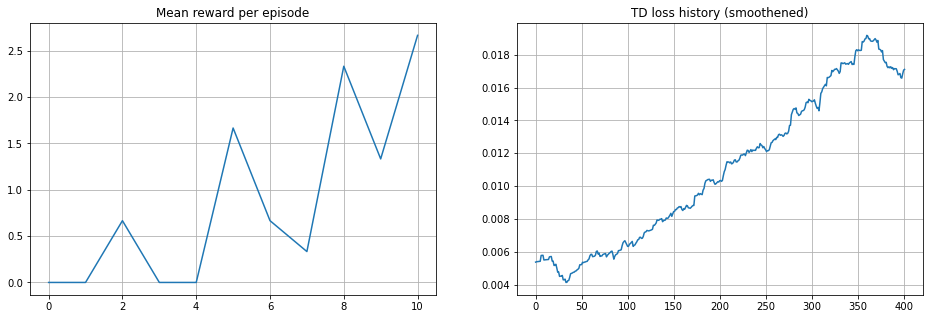

100%|████████████████████████████████████████████████████████████████████████████| 10001/10001 [09:06<00:00, 18.29it/s]


In [26]:
state = env.reset()
for step in trange(total_steps + 1):
    
    # reduce exploration as we progress
    agent.epsilon = epsilon_schedule(start_epsilon, end_epsilon, step, eps_decay_final_step)

    # take timesteps_per_epoch and update experience replay buffer
    _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

    # train by sampling batch_size of data from experience replay
    states, actions, rewards, next_states, done_flags = exp_replay.sample(batch_size)
    
    with tf.GradientTape() as tape:
        # loss = <compute TD loss>
        loss = compute_td_loss(agent, target_network, 
                               states, actions, rewards, next_states, done_flags,                  
                               gamma=0.99)

    gradients = tape.gradient(loss, agent.model.trainable_variables)
    clipped_grads = [tf.clip_by_norm(g, max_grad_norm) for g in gradients]
    optimizer.apply_gradients(zip(clipped_grads, agent.model.trainable_variables))


    if step % loss_freq == 0:
        td_loss_history.append(loss.numpy())

    if step % refresh_target_network_freq == 0:
        # Load agent weights into target_network
        target_network.model.set_weights(agent.model.get_weights())

    if step % eval_freq == 0:
        # eval the agent
        mean_rw_history.append(evaluate(
            make_env(env_name, seed=step), agent, n_games=3, greedy=True, t_max=1000)
        )

        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" %
              (len(exp_replay), agent.epsilon))

        plt.figure(figsize=[16, 5])
        plt.subplot(1, 2, 1)
        plt.title("Mean reward per episode")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(td_loss_history[-1])
        plt.subplot(1, 2, 2)
        plt.title("TD loss history (smoothened)")
        plt.plot(smoothen(td_loss_history))
        plt.grid()

        plt.show()

In [27]:
final_score = evaluate(
  make_env(env_name),
  agent, n_games=1, greedy=True, t_max=1000
)
print('final score:', final_score)


final score: 0.0


The training for 100 steps will not produce any result. It may be close to 100,000 steps or so before you see any semblance of learning by agent. Do not worry about any exceptions you may get above. That is because the first graph has no data point for 100 steps. First data point for the left graph is generated only at 1000th step.

In [28]:
def generate_animation(env, agent, save_dir):
    
    try:
        env = gym.wrappers.Monitor(
            env, save_dir, video_callable=lambda id: True, force=True, mode='evaluation')
    except gym.error.Error as e:
        print(e)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    state = env.reset()
    print("initial shape:", state.shape)
    reward = 0
    t = 0
    while True:
        qvalues = agent.get_qvalues(np.array([state]))
        action = qvalues.argmax(axis=-1)[0]
        state, r, done, _ = env.step(action)
        reward += r
        t += 1
        if done or t >=1000:
            print('Got reward: {}'.format(reward))
            break
            
def display_animation(filepath):
    video = io.open(filepath, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii')))

In [29]:
# Animate learned policy
save_dir='./videos/tensorflow/6_2'
env = make_env(env_name)
generate_animation(env, agent, save_dir=save_dir)
[filepath] = glob.glob(os.path.join(save_dir, '*.mp4'))
display_animation(filepath)


initial shape: (84, 84, 4)
Got reward: 2.0
